In [1]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import json
from database.comet import Comet
from processor.processor import Processor as p
from time import sleep
import matplotlib.pyplot as plt
import math

In [2]:
comet = Comet()

In [3]:
start = datetime(2021,5,10)
end = datetime(2022,1,1)

In [4]:
comet.connect()
prices = comet.retrieve(f"alpha_prices")
comet.disconnect()

In [5]:
prices.head(10)

,date,open,high,low,close,volume,market_cap,crypto
0,2022-01-09,1.182,1.185,1.172,1.182,3844276.90000000,3844276.90000000,ADA
1,2022-01-08,1.209,1.254,1.124,1.181,169730473.68000001,169730473.68000001,ADA
2,2022-01-07,1.279,1.285,1.189,1.210,209806013.19999999,209806013.19999999,ADA
3,2022-01-06,1.230,1.297,1.186,1.280,175754407.59999999,175754407.59999999,ADA
4,2022-01-05,1.310,1.353,1.193,1.230,158740088.19999999,158740088.19999999,ADA
5,2022-01-04,1.319,1.352,1.295,1.309,94479305.90000001,94479305.90000001,ADA
6,2022-01-03,1.378,1.378,1.310,1.319,87155825.90000001,87155825.90000001,ADA
7,2022-01-02,1.379,1.391,1.342,1.377,81011860.40000001,81011860.40000001,ADA
8,2022-01-01,1.308,1.380,1.306,1.380,69007607.50000000,69007607.50000000,ADA
9,2021-12-31,1.359,1.383,1.281,1.308,120612337.30000000,120612337.30000000,ADA


In [6]:
symbols = ['ADA', 'BTC', 'DOGE', 'ETH', 'SHIB', 'LUNA',
       'AVAX', 'LTC', 'DOT']

In [16]:
start = datetime(2021,1,1)
end = datetime(2022,1,1)
date = start
trades = []
for rt in [1,3,7,14]:
    for projection_day in [1,3,7]:
        sim = prices.copy()
        ns = []
        for crypto in sim["crypto"].unique():
            crypto_sim = sim[sim["crypto"]==crypto].copy()
            crypto_sim.sort_values("date",inplace=True)
            crypto_sim["p1"] = crypto_sim["close"].pct_change(rt)
            crypto_sim["p2"] = crypto_sim["p1"].pct_change()
            crypto_sim["p3"] = crypto_sim["p2"].pct_change()
            crypto_sim["p_sign_change"] = [row[1]["p2"] * row[1]["p3"] < 0 for row in crypto_sim.iterrows()]
            crypto_sim["sell_price"] = crypto_sim["close"].shift(-projection_day) 
            crypto_sim["delta"] = (crypto_sim["sell_price"] - crypto_sim["close"]) / crypto_sim["close"]
            crypto_sim["sell_date"] = crypto_sim["date"].shift(-projection_day)
            ns.append(crypto_sim)
        final = pd.concat(ns)
        final = final[(final["date"] < end) & (final["crypto"].isin(symbols))]
        print(rt,projection_day,final.index.size)
        while date < end:
            offerings = final[(final["date"]==date) & (final["delta"]>0)].sort_values("delta",ascending=False)
            if offerings.index.size < 1:
                date = date + timedelta(days=1)
            else:
                trade = offerings.iloc[0]
                trade["rt"] = rt
                trade["projection_day"] = projection_day
                trades.append(trade)
                date = trade["sell_date"] + timedelta(days=1)

1 1 6576


C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


1 3 6576
1 7 6576
3 1 6576
3 3 6576
3 7 6576
7 1 6576
7 3 6576
7 7 6576
14 1 6576
14 3 6576
14 7 6576


In [17]:
t = pd.DataFrame(trades)

In [18]:
t

,date,open,high,low,close,volume,market_cap,crypto,p1,p2,p3,p_sign_change,sell_price,delta,sell_date,rt,projection_day
2698,2021-01-01,0.004672,0.005697,0.004601,0.00568,3019717963.00000000,3019717963.00000000,DOGE,0.216040,20.816711,-33.513434,True,0.010526,0.853239,2021-01-02,1,1
371,2021-01-03,0.177400,0.209600,0.172550,0.20615,1201451449.29999995,1201451449.29999995,ADA,0.161932,11.168540,-9.057485,True,0.225280,0.092797,2021-01-04,1,1
369,2021-01-05,0.225180,0.264290,0.206960,0.25873,1478887679.32999992,1478887679.32999992,ADA,0.148482,0.600081,-2.405532,True,0.333090,0.287404,2021-01-06,1,1
7203,2021-01-07,4.580300,4.820500,4.182700,4.47070,1471492.75000000,1471492.75000000,AVAX,-0.023609,-1.305263,1.282715,True,5.700000,0.274968,2021-01-08,1,1
6694,2021-01-09,0.848400,0.850000,0.798000,0.81370,5982533.56000000,5982533.56000000,LUNA,-0.040335,2.717754,-3.578835,True,0.843500,0.036623,2021-01-10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8330,2021-12-21,24.070000,25.590000,23.740000,25.16000,7752931.61000000,7752931.61000000,DOT,0.045285,-2.580496,-91.062940,False,27.220000,0.081876,2021-12-22,1,1
6346,2021-12-23,85.350000,95.310000,84.260000,94.39000,7795048.49000000,7795048.49000000,LUNA,0.105528,-5.822806,3.334639,True,95.780000,0.014726,2021-12-24,1,1
8326,2021-12-25,28.140000,29.120000,27.940000,28.84000,3990671.82000000,3990671.82000000,DOT,0.024876,-1.711150,0.147811,True,31.320000,0.085992,2021-12-26,1,1
8322,2021-12-29,27.840000,28.960000,26.480000,26.82000,9578005.60000000,9578005.60000000,DOT,-0.036292,-0.642052,-1.079533,False,27.540000,0.026846,2021-12-30,1,1


In [19]:
analysis = []
for rt in [1,3,7,14]:
    for projection_day in [1,3,7]:
        try:
            iteration_trades = t[(t["rt"]==rt)
                                 &(t["projection_day"]==projection_day)
                                ]
            initial = 100
            for delta in iteration_trades["delta"]:
                 initial = initial * (1+delta)
            iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
            iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
            days = iteration_trades["days"].mean()
            analysis.append({"rt":rt,"projection_day":projection_day,"trades":iteration_trades.index.size,"pv":initial,"days":days})
        except Exception as e:
            print(str(e))

In [20]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False)

,rt,projection_day,trades,pv,days
0,1,1,172,1.302547e+11,1.0
1,1,3,0,1.000000e+02,NaN
2,1,7,0,1.000000e+02,NaN
3,3,1,0,1.000000e+02,NaN
4,3,3,0,1.000000e+02,NaN
5,3,7,0,1.000000e+02,NaN
6,7,1,0,1.000000e+02,NaN
7,7,3,0,1.000000e+02,NaN
8,7,7,0,1.000000e+02,NaN
9,14,1,0,1.000000e+02,NaN


In [24]:
a

,rt,projection_day,trades,pv,days
0,1,1,172,1.302547e+11,1.0
1,1,3,0,1.000000e+02,NaN
2,1,7,0,1.000000e+02,NaN
3,3,1,0,1.000000e+02,NaN
4,3,3,0,1.000000e+02,NaN
5,3,7,0,1.000000e+02,NaN
6,7,1,0,1.000000e+02,NaN
7,7,3,0,1.000000e+02,NaN
8,7,7,0,1.000000e+02,NaN
9,14,1,0,1.000000e+02,NaN


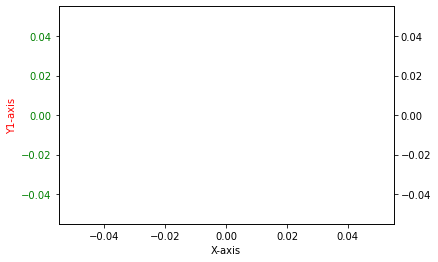

In [21]:
top = a.sort_values("pv",ascending=False).iloc[0]
research = t[
    (t["rt"]==rt) & (t["projection_day"]==projection_day)
]
research.reset_index(drop=True,inplace=True)
window = research.reset_index()
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(window["p2"], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'green') 
ax1.plot(window["p3"], color = 'green') 
# Adding Twin Axes

ax2 = ax1.twinx() 
# ax2.plot(window["p1"],color="blue")
ax2.plot(window["delta"],color="orange")
plt.show()

In [22]:
research.mean()

C:\Users\eric\AppData\Local\Temp/ipykernel_11480/1769538717.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  research.mean()


open              NaN
high              NaN
low               NaN
close             NaN
volume            NaN
market_cap        NaN
crypto            NaN
p1                NaN
p2                NaN
p3                NaN
p_sign_change     NaN
sell_price        NaN
delta             NaN
rt                NaN
projection_day    NaN
dtype: object

In [14]:
window.index.size

28

In [215]:
# from derivative import dxdt
# import numpy as np
# research = final[final["crypto"]=="btc"].dropna()
# t = research.index
# x = research["value"]

# # 1. Finite differences with central differencing using 3 points.
# result1 = dxdt(x, t, kind="finite_difference", k=3)
# result2 = dxdt(result1, t, kind="finite_difference", k=3)
# result3 = dxdt(result2, t, kind="finite_difference", k=3)
# research = research.iloc[3:]
# research["d1"] = result1[3:]
# research["d2"] = result2[3:]
# research["d3"] = result3[3:]
# # 2. Savitzky-Golay using cubic polynomials to fit in a centered window of length 1
# result2 = dxdt(x, t, kind="savitzky_golay", left=.5, right=.5, order=3)

# # 3. Spectral derivative
# result3 = dxdt(x, t, kind="spectral")

# # 4. Spline derivative with smoothing set to 0.01
# result4 = dxdt(x, t, kind="spline", s=1e-2)

# # 5. Total variational derivative with regularization set to 0.01
# result5 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)